In [5]:
import os
import cv2
import numpy as np
import absl.logging
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from pathlib import Path


# Mencoba untuk supress (menyembunyikan) log warning dari TensorFlow mediapipe
# Harapan: untuk membuat output lebih bersih tanpa log yang tidak berpengaruh
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['GLOG_minloglevel'] = '2'
absl.logging.set_verbosity(absl.logging.ERROR)


class FaceLandmark:

    BASE_ROOT_DIR = Path(os.getcwd()).parent

    BASE_MODEL_PATH = "src/face/tasks/face_landmarker.task"

    MODEL_PATH = Path(BASE_ROOT_DIR, BASE_MODEL_PATH)

    def __init__(self):

        # Jika file model tidak ditemukan, raise dengan sebuah error
        # untuk menghindari kesalahan saat inisialisasi model FaceLandmark
        if not self.MODEL_PATH.exists():
            raise FileNotFoundError(f"Model file not found at {self.MODEL_PATH}")

        # Inisialisasi base options dengan menyertakan path model yang benar
        self.base_options = python.BaseOptions(model_asset_path=self.MODEL_PATH.as_posix())

        # Inisialisasi options untuk FaceLandmarker
        # Beberapa parameter ditambahkan untuk konfigurasi yang lebih baik, seperti:
        # num_faces -> untuk menentukan jumlah wajah yang akan dideteksi
        # min_tracking_confidence -> untuk mengatur ambang kepercayaan pelacakan wajah
        # min_face_detection_confidence -> untuk mengatur ambang kepercayaan deteksi wajah
        # min_face_presence_confidence -> untuk mengatur ambang kepercayaan keberadaan wajah
        # running_mode -> untuk menentukan mode operasi (IMAGE, VIDEO, LIVE_STREAM)
        self.options = vision.FaceLandmarkerOptions(base_options=self.base_options,
                                                    num_faces=1,
                                                    min_tracking_confidence=0.7,
                                                    min_face_detection_confidence=0.7,
                                                    min_face_presence_confidence=0.7,
                                                    running_mode=vision.RunningMode.IMAGE)
        
        # Membuat instance Face Landmarker dengan opsi yang telah ditentukan
        self.landmarker = vision.FaceLandmarker.create_from_options(self.options)


    def detect(self, image: np.ndarray) -> vision.FaceLandmarkerResult: #type: ignore
        """
        Melakukan deteksi landmarks dengan citra input

        Args:
            image: Citra input dalam format numpy ndarray

        Returns:
            FaceLandmarkerResult: Hasil deteksi dari FaceLandmarker

        Raises:
            ValueError: Jika citra input tidak valid
        """

        # Jika citra bukan merupakan instance dari numpy ndarray
        # Maka raise dengan ValueError yang menunjukkan image harus berupa numpy ndarray
        if not isinstance(image, np.ndarray):
            raise ValueError("Input image must be a numpy ndarray.")

        # Jika citra tidak memiliki value apapun meskipun instance dari numpy ndarray
        # Maka raise dengan ValueError yang menunjukkan image tidak boleh kosong (invalid)
        if image.size == 0:
            raise ValueError("Input image is empty.")

        # Memastikan citra dalam format RGB sebelum diproses
        # Hal ini diperlukan oleh MediaPipe Face Landmarker
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=rgb_image)

        # Melakukan deteksi landmarks pada citra RGB
        return self.landmarker.detect(mp_image)

In [6]:
import cv2


# Menargetkan pengujian deteksi landmark pada sebuah file video 
TARGET_FILE=os.path.join(Path.home(), "datasets", "primary-converted", "8-12-2025/aaisyah_nursalsabiil_ni_patriarti_1765168488512/q1/answer_1_15d591ce-051a-47f2-ac38-367c1e6189c7_sec.avi")

# Mengambil hanya satu frame untuk pengujian deteksi landmark
ret, frame = cv2.VideoCapture(TARGET_FILE).read()

# Instansiasi object FaceLandmark dan melakukan deteksi landmark pada frame
face_landmark   = FaceLandmark()
landmark_result = face_landmark.detect(frame)

W0000 00:00:1769901966.539624  359639 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1769901966.558564  359643 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1769901966.573354  359643 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [7]:
# Menampilkan jumlah titik landmark pada wajah yang terdeteksi pada frame
# menggunakan pendekatan FaceLandmarker dari MediaPipe Vision (latest v0.10.32).
print(len(landmark_result.face_landmarks[0]))

478


Hasil dari deteksi landmark menggunakan MediaPipe Vision yaitu sekitar 478 titik pada bagian wajah subjek.

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mediapipe.tasks.python.vision.face_landmarker import FaceLandmarksConnections 


class FaceLandmarkVisualizer:

    def __init__(self, landmark_result): #type: ignore
        if not hasattr(landmark_result, 'face_landmarks'):
            raise ValueError("landmark_result must have 'face_landmarks' attribute.")
        self.landmark_result = landmark_result


    def draw(self, image: np.ndarray, connections='tesselation') -> np.ndarray:
        """
        Menggambar titik landmark wajah pada input citra
        Args:
            image: Citra input dalam format numpy ndarray
            connections: 'tesselation' (full mesh) atau 'contours' (outline only)
        Returns:
            image: Citra output dengan titik landmark yang digambar
        Raises:
            ValueError: Jika citra input tidak valid
        """
        if not isinstance(image, np.ndarray):
            raise ValueError("Input image must be a numpy ndarray.")
        
        if image.size == 0:
            raise ValueError("Input image is empty.")
        
        if connections == 'contours':
            connection_set = FaceLandmarksConnections.FACE_LANDMARKS_CONTOURS
        else:
            connection_set = FaceLandmarksConnections.FACE_LANDMARKS_TESSELATION
        
        h, w, _ = image.shape
        
        # Menggambar koneksi dan titik landmark
        for normalized_landmark in self.landmark_result.face_landmarks:
            for connection in connection_set:

                # Menggunakan start dan end index dari koneksi untuk menggambar garis
                start_idx = connection.start
                end_idx = connection.end
                
                if start_idx < len(normalized_landmark) and end_idx < len(normalized_landmark):
                    start_point = normalized_landmark[start_idx]
                    end_point = normalized_landmark[end_idx]
                    
                    p1 = (int(start_point.x * w), int(start_point.y * h))
                    p2 = (int(end_point.x * w), int(end_point.y * h))
                    
                    cv2.line(image, p1, p2, (255, 0, 0), 1)
            
            for point in normalized_landmark:
                x_px = int(point.x * w)
                y_px = int(point.y * h)
                cv2.circle(image, (x_px, y_px), 1, (0, 255, 0), -1)
        
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

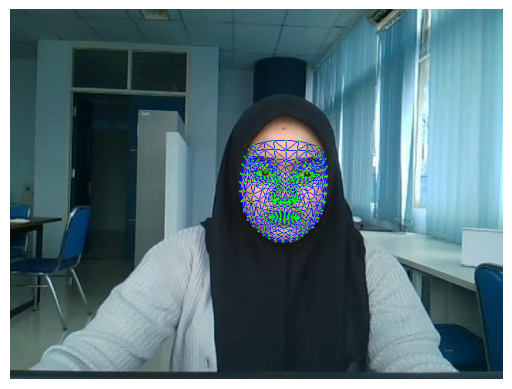

In [9]:
facial_landmark_visualizer = FaceLandmarkVisualizer(landmark_result=landmark_result)
facial_landmark_visualizer.draw(frame)

Memotong gambar berdasarkan facial landmark yang sudah didapatkan dari MediaPipe Vision

In [10]:
import numpy as np
from mediapipe.tasks.python.vision.face_landmarker import FaceLandmarkerResult


def crop(image: np.ndarray, landmark_result: FaceLandmarkerResult, margin: float = 0.2) -> np.ndarray: #type: ignore
    """
    Memotong wajah dari citra berdasarkan landmark yang terdeteksi

    Args:
        image: Citra input dalam format numpy ndarray
        landmark_result: Hasil deteksi dari FaceLandmarker
        margin: Margin tambahan di sekitar wajah (dalam rasio)

    Returns:
        cropped_face: Citra wajah yang telah dipotong

    Raises:
        ValueError: Jika citra input tidak valid atau tidak ada wajah yang terdeteksi
    """

    if not isinstance(image, np.ndarray):
        raise ValueError("Input image must be a numpy ndarray.")

    if image.size == 0:
        raise ValueError("Input image is empty.")

    if not landmark_result.face_landmarks:
        raise ValueError("No face landmarks detected.")

    h, w, _ = image.shape

    # Mengambil landmark wajah pertama yang terdeteksi
    landmarks = landmark_result.face_landmarks[0]

    x_coords = [int(landmark.x * w) for landmark in landmarks]
    y_coords = [int(landmark.y * h) for landmark in landmarks]

    x_min, x_max = min(x_coords), max(x_coords)
    y_min, y_max = min(y_coords), max(y_coords)

    # Menambahkan margin
    x_margin = int((x_max - x_min) * margin)
    y_margin = int((y_max - y_min) * margin)

    x_min = max(0, x_min - x_margin)
    x_max = min(w, x_max + x_margin)
    y_min = max(0, y_min - y_margin)
    y_max = min(h, y_max + y_margin)

    cropped_face = image[y_min:y_max, x_min:x_max]

    return cropped_face

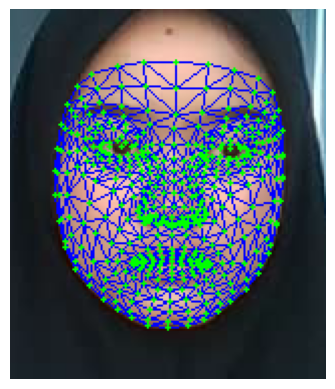

In [11]:
import matplotlib.pyplot as plt


cropped_face = crop(image=frame, landmark_result=landmark_result, margin=0.2)

plt.imshow(cv2.cvtColor(cropped_face, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()